# Processamento dos Datasets: LFW
https://colab.research.google.com/drive/1CYV5oxvDnX5Onf5_5zK5GJAdwpa8dxls?authuser=0#scrollTo=SV1YY8A1vtSU

In [1]:
pip install tensorflow tensorflow-datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import numpy as np
from tqdm import tqdm

# Download e carregamento do dataset LFW
print("Baixando o dataset LFW via TensorFlow...")
lfw_dataset, lfw_info = tfds.load('lfw', with_info=True, as_supervised=False)

# Diretório para salvar as imagens processadas
output_dir = "lfw_processed"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Tamanho alvo para VGG
target_size = (112, 112)

# Dicionário para agrupar exemplos por pessoa
person_examples = {}

# Processar o conjunto de treinamento
for example in tqdm(tfds.as_numpy(lfw_dataset['train']), desc="Processando dataset"):
    image = example['image']
    person_name = example['label'].decode('utf-8')  # Converter bytes para string

    # Criar uma entrada no dicionário para esta pessoa, se não existir
    if person_name not in person_examples:
        person_examples[person_name] = []

    # Adicionar a imagem à lista desta pessoa
    person_examples[person_name].append(image)

# Salvar imagens por pessoa
for person_name, images in tqdm(person_examples.items(), desc="Salvando imagens"):
    # Criar diretório para esta pessoa
    person_dir = os.path.join(output_dir, person_name.replace(" ", "_"))
    if not os.path.exists(person_dir):
        os.makedirs(person_dir)

    # Salvar cada imagem desta pessoa
    for i, img in enumerate(images):
        # Converter de RGB para BGR (para OpenCV)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Redimensionar para o tamanho alvo
        img_resized = cv2.resize(img_bgr, target_size)

        # Salvar a imagem
        img_path = os.path.join(person_dir, f"{person_name.replace(' ', '_')}_{i:03d}.jpg")
        cv2.imwrite(img_path, img_resized)

print(f"Processamento concluído! Imagens salvas em {output_dir}")

Baixando o dataset LFW via TensorFlow...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.LMJ9IU_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.


Salvando imagens: 100%|██████████| 5749/5749 [00:04<00:00, 1260.30it/s]

Processamento concluído! Imagens salvas em lfw_processed


In [4]:
import os
import shutil
from tqdm import tqdm

# Diretório com imagens processadas
processed_dir = "lfw_processed"
filtered_dir = "lfw_filtered"

# Número mínimo de imagens por pessoa
min_images = 30  # Ajuste conforme necessário

# Criar diretório de destino
if not os.path.exists(filtered_dir):
    os.makedirs(filtered_dir)

# Listar todos os diretórios de pessoas
all_people = [d for d in os.listdir(processed_dir) if os.path.isdir(os.path.join(processed_dir, d))]
qualified_people = []

# Filtrar pessoas com número mínimo de imagens
for person in all_people:
    person_dir = os.path.join(processed_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if len(images) >= min_images:
        qualified_people.append(person)

print(f"Encontradas {len(qualified_people)} pessoas com pelo menos {min_images} imagens.")

# Copiar apenas as pessoas qualificadas
for person in tqdm(qualified_people, desc="Copiando pessoas qualificadas"):
    src_dir = os.path.join(processed_dir, person)
    dst_dir = os.path.join(filtered_dir, person)

    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # Copiar todas as imagens
    images = [f for f in os.listdir(src_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    for img in images:
        src_path = os.path.join(src_dir, img)
        dst_path = os.path.join(dst_dir, img)
        shutil.copy2(src_path, dst_path)

print(f"Dataset filtrado criado com {len(qualified_people)} pessoas!")

Encontradas 34 pessoas com pelo menos 30 imagens.


Copiando pessoas qualificadas: 100%|██████████| 34/34 [00:00<00:00, 85.69it/s]

Dataset filtrado criado com 34 pessoas!


In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Diretório de origem (dataset LFW processado)
source_dir = "lfw_filtered"  # ou "lfw_filtered" se já filtrou
target_dir = "lfw_faces_extracted"

# Tamanho alvo para o modelo VGG
target_size = (224, 224)

# Criar diretório de destino se não existir
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Carregar o classificador de faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Alternativa: usar um detector de face mais robusto, se disponível
# Comentar o código acima e descomentar abaixo se quiser usar o DNN
"""
# Usar detector DNN para melhor precisão
face_model_file = "opencv_face_detector_uint8.pb"
face_model_config = "opencv_face_detector.pbtxt"

# Verificar se os arquivos do modelo existem
if not os.path.isfile(face_model_file) or not os.path.isfile(face_model_config):
    print("Baixando modelo de detecção facial DNN...")
    os.system(f"curl -O https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/opencv_face_detector_uint8.pb")
    os.system(f"curl -O https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/opencv_face_detector.pbtxt")

# Carregar o modelo DNN
face_net = cv2.dnn.readNet(face_model_file, face_model_config)
"""

# Estatísticas
total_images = 0
faces_detected = 0
no_face_detected = 0

# Processar cada subdiretório (cada pessoa)
person_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for person in tqdm(person_dirs, desc="Processando pessoas"):
    # Criar diretório para esta pessoa no destino
    person_target_dir = os.path.join(target_dir, person)
    if not os.path.exists(person_target_dir):
        os.makedirs(person_target_dir)

    # Encontrar todas as imagens desta pessoa
    person_dir = os.path.join(source_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Processar cada imagem
    for img_file in images:
        total_images += 1
        img_path = os.path.join(person_dir, img_file)

        try:
            # Carregar a imagem
            img = cv2.imread(img_path)
            if img is None:
                print(f"Erro ao carregar: {img_path}")
                continue

            # Converter para escala de cinza para detecção facial
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Método Haarcascade
            faces = face_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )

            # Método DNN (se descomentar o código DNN acima)
            """
            # Preparar blob da imagem para o DNN
            blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
            face_net.setInput(blob)
            detections = face_net.forward()

            faces = []
            img_height, img_width = img.shape[:2]

            # Filtrar detecções com confiança > 0.5
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > 0.5:
                    x1 = int(detections[0, 0, i, 3] * img_width)
                    y1 = int(detections[0, 0, i, 4] * img_height)
                    x2 = int(detections[0, 0, i, 5] * img_width)
                    y2 = int(detections[0, 0, i, 6] * img_height)
                    # Converter para formato (x, y, w, h)
                    faces.append((x1, y1, x2-x1, y2-y1))
            """

            if len(faces) > 0:
                faces_detected += 1

                # Usar a face maior (presumivelmente a principal)
                face = max(faces, key=lambda f: f[2] * f[3])  # Face com maior área
                x, y, w, h = face

                # Adicionar uma margem ao redor da face (20% extra)
                margin_x = int(w * 0.2)
                margin_y = int(h * 0.2)

                # Garantir que as coordenadas com margem estejam dentro da imagem
                x1 = max(0, x - margin_x)
                y1 = max(0, y - margin_y)
                x2 = min(img.shape[1], x + w + margin_x)
                y2 = min(img.shape[0], y + h + margin_y)

                # Extrair a face com margem
                face_img = img[y1:y2, x1:x2]

                # Redimensionar para o tamanho alvo
                face_resized = cv2.resize(face_img, target_size)

                # Salvar a imagem processada
                save_path = os.path.join(person_target_dir, img_file)
                cv2.imwrite(save_path, face_resized)
            else:
                no_face_detected += 1
                # Se não encontrar face, redimensionar a imagem original
                img_resized = cv2.resize(img, target_size)

                # Salvar a imagem processada
                save_path = os.path.join(person_target_dir, img_file)
                cv2.imwrite(save_path, img_resized)

        except Exception as e:
            print(f"Erro ao processar {img_path}: {str(e)}")

# Exibir estatísticas
print(f"Processamento concluído!")
print(f"Total de imagens processadas: {total_images}")
print(f"Faces detectadas: {faces_detected} ({faces_detected/total_images*100:.2f}%)")
print(f"Imagens sem faces detectadas: {no_face_detected} ({no_face_detected/total_images*100:.2f}%)")

Processando pessoas: 100%|██████████| 34/34 [00:19<00:00,  1.71it/s]

Processamento concluído!
Total de imagens processadas: 2370
Faces detectadas: 2342 (98.82%)
Imagens sem faces detectadas: 28 (1.18%)


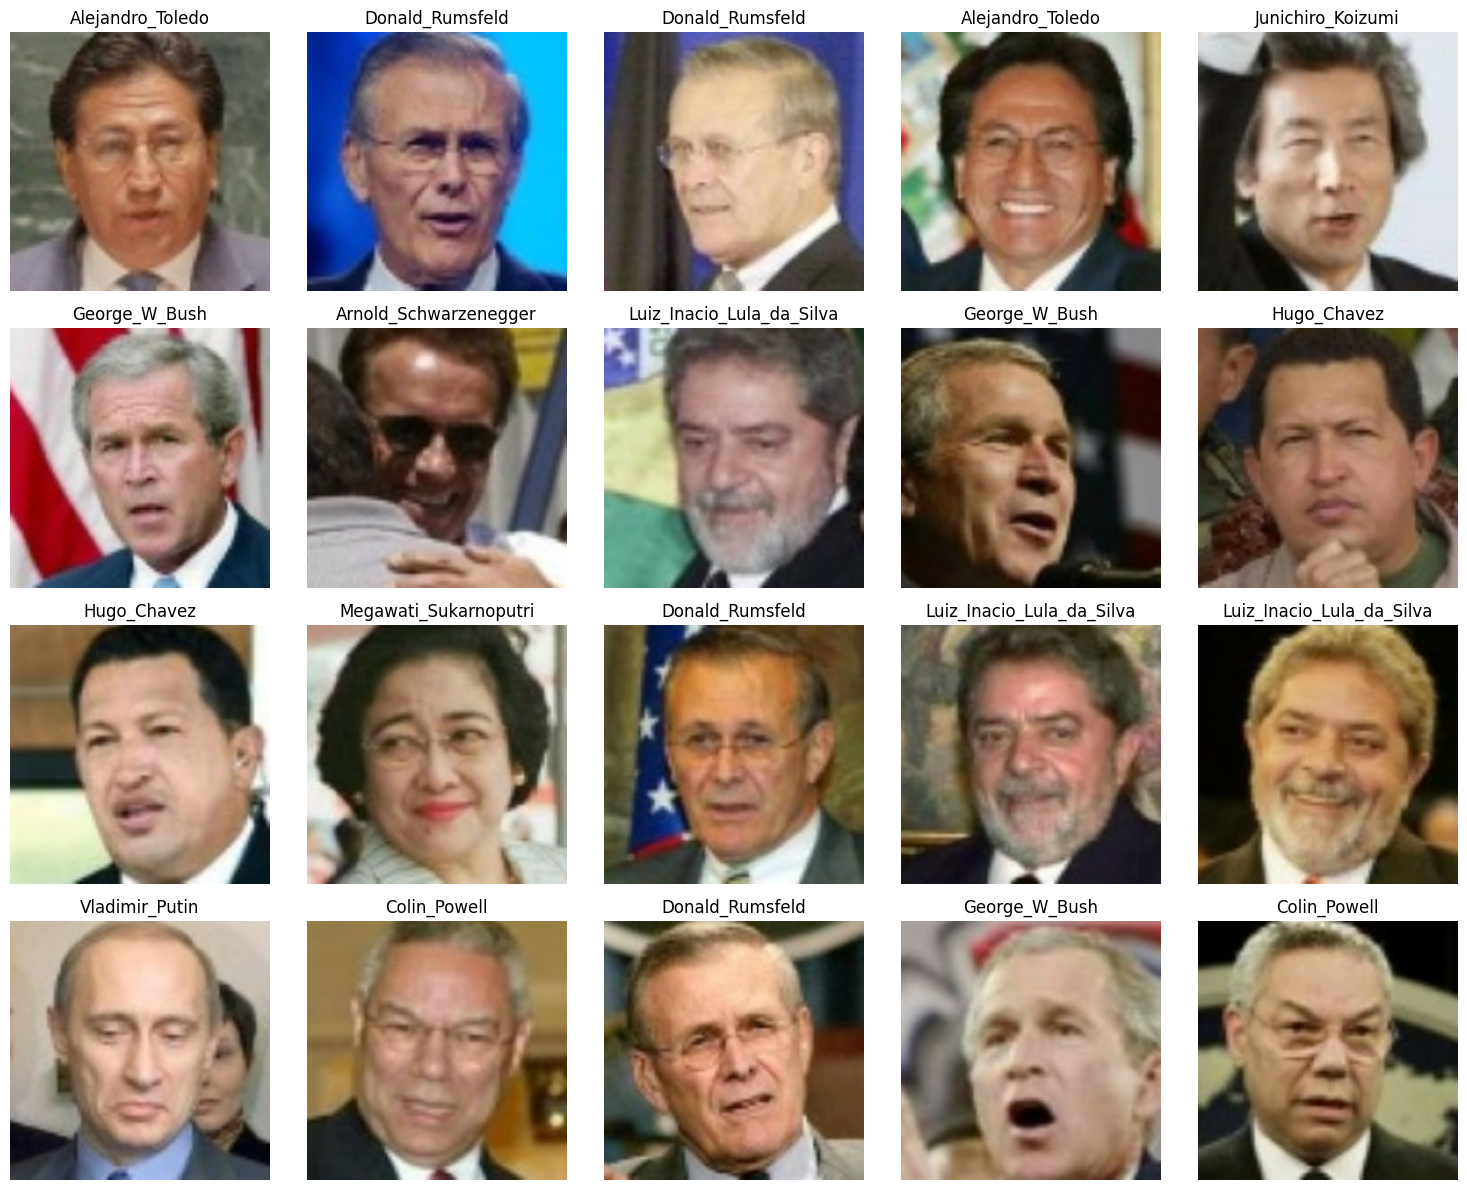

In [6]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

# Script para visualizar algumas faces detectadas aleatoriamente
def visualize_random_faces(faces_dir, num_samples=20):
    # Coletar todos os caminhos de imagens
    all_images = []
    for root, _, files in os.walk(faces_dir):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                all_images.append(os.path.join(root, file))

    # Selecionar amostras aleatórias
    if len(all_images) < num_samples:
        samples = all_images
    else:
        samples = random.sample(all_images, num_samples)

    # Configurar o plot
    rows = int(np.ceil(num_samples / 5))
    cols = min(5, num_samples)
    plt.figure(figsize=(15, 3 * rows))

    # Mostrar as imagens
    for i, img_path in enumerate(samples):
        if i < num_samples:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(os.path.basename(os.path.dirname(img_path)))
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('face_samples.png')
    plt.show()

# Usar a função com o diretório de faces extraídas
visualize_random_faces("lfw_faces_extracted", 20)

In [7]:
import os
import zipfile
from tqdm import tqdm

# Diretório com as faces extraídas
faces_dir = "lfw_faces_extracted"  # ou "lfw_faces_extracted" dependendo do método que usou
output_zip = "lfw_faces_for_edgeimpulse.zip"

# Verificar se o diretório existe
if not os.path.exists(faces_dir):
    print(f"Erro: O diretório {faces_dir} não existe!")
    exit(1)

# Contar arquivos para a barra de progresso
total_files = 0
for root, _, files in os.walk(faces_dir):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            total_files += 1

print(f"Comprimindo {total_files} imagens...")

# Criar arquivo ZIP
with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    with tqdm(total=total_files, desc="Comprimindo") as pbar:
        for root, _, files in os.walk(faces_dir):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    file_path = os.path.join(root, file)
                    # Preservar a estrutura de diretórios no arquivo ZIP
                    arcname = os.path.relpath(file_path, os.path.dirname(faces_dir))
                    zipf.write(file_path, arcname)
                    pbar.update(1)

print(f"Dataset comprimido com sucesso em {output_zip}")
print(f"Tamanho do arquivo: {os.path.getsize(output_zip) / (1024*1024):.2f} MB")

Comprimindo 2370 imagens...


Comprimindo: 100%|██████████| 2370/2370 [00:01<00:00, 1919.26it/s]

Dataset comprimido com sucesso em lfw_faces_for_edgeimpulse.zip
Tamanho do arquivo: 29.05 MB
